In [24]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [25]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [26]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [27]:
# define a function for residual plot
def residual_plot(y_train, y_train_pred, y_test, y_test_pred):
  # Residual plot
    plt.scatter(
      y_train_pred,
      y_train_pred - y_train,
      c='blue',
      marker='o',
      label='Training data')
    plt.scatter(
      y_test_pred,
      y_test_pred - y_test,
      c='green',
      marker='s',
      label='Test data')

    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    xmin = min(y_train_pred.min(), y_test_pred.min())
    xmax = max(y_train_pred.max(), y_test_pred.max())
    plt.hlines(y=0, xmin=xmin, xmax=xmax, lw=2, color='red')
    plt.xlim([xmin, xmax])
    plt.tight_layout()
    plt.savefig('Lab04-2_106062541.png', dpi=300)
    plt.show()

In [28]:
# select features and train model by yourself
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import itertools

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

#Training data points: 1491
#Testing data points: 639


In [29]:
# PCA

# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

R = np.dot(X_train.T, X_train)/X_train.shape[0]

eigen_vals, eigen_vecs = np.linalg.eigh(R)
print('Eigenvalues：\n%s\n' % eigen_vals)

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

Eigenvalues：
[ -4.60524826e-16   1.60248578e-01   4.66638279e-01   5.57209804e-01
   8.58367910e-01   9.58490670e-01   1.02315891e+00   1.10047405e+00
   1.30292576e+00   1.69381516e+00   2.87867088e+00]



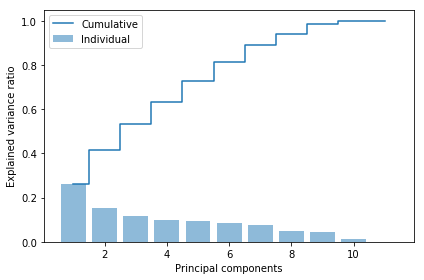

In [30]:
import matplotlib.pyplot as plt
tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
        label='Individual')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
         label='Cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [31]:
W_4D = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                  eigen_pairs[1][1][:, np.newaxis], 
                  eigen_pairs[2][1][:, np.newaxis], 
                  eigen_pairs[3][1][:, np.newaxis]))

X_train_PCA = X_train.dot(W_4D)
X_test_PCA = X_test.dot(W_4D)
print('#Training data features: %d' % X_train_PCA.shape[1])
print('#Testing data features: %d' % X_test_PCA.shape[1])


#Training data features: 4
#Testing data features: 4


[Forest]
MSE train: 431.93, test: 3129.86
R^2 train: 0.97, test: 0.80


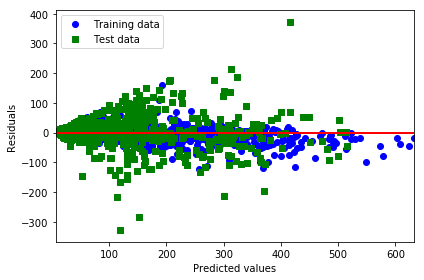

In [37]:
from sklearn.ensemble import RandomForestRegressor

print('[Forest]')
forest = RandomForestRegressor(
    n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest = forest.fit(X_train_PCA, y_train)

y_train_pred = forest.predict(X_train_PCA)
y_test_pred = forest.predict(X_test_PCA)

print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

residual_plot(y_train, y_train_pred, y_test, y_test_pred)